In [32]:
using Plots, LaTeXStrings
using Plots.PlotMeasures
empty!(ARGS)
push!(ARGS, "G:/Hamburg/b20.0_mu0.4/lDGAConfig.toml")
#push!(ARGS, "/home/julisn/Hamburg/ED_data/cuprate_test/b20.0_mu1.0/lDGAConfig.toml")# "G:/tmp_ED_data/U2.0_b20.0_mu1.0.toml")
include(joinpath(@__DIR__,"../examples/example00_lDGA.jl"))
mu_str = "04"
using LaTeXStrings

  Activating project at `G:\Codes\LadderDGA.jl`


[ Info: Reading Inputs...
[ Info: Setting up calculation for kGrid 2Dsc-0.25-0.05-0.025 of size 10
┌ Info: Inputs Read. Starting Computation.
│     Local susceptibilities with ranges are:
│     χLoc_m(1:301) = 0.3838, χLoc_d(1:301) = 0.1017
│     sum χupup check (plain ?≈? tail sub ?≈? imp_dens ?≈? n/2 (1-n/2)): 0.2401531297823682 ?=? 0.2427835212727256 ?≈? 0.2427835212727254 ≟ 0.24275850716113093"
│ Local EoM check for the first 5 frequencies: 0.0033, 0.0033, 0.0033, 0.0033, 0.0033  
└     


DBG: NOT using diagonal terms in λ₀


[ Info: m channel: |∑χ(q=0,ω≠0)| = 0.005219445084 ≟ 0
[ Info: d channel: |∑χ(q=0,ω≠0)| = 0.004454577569 ≟ 0


DBG: NOT using diagonal terms in λ₀


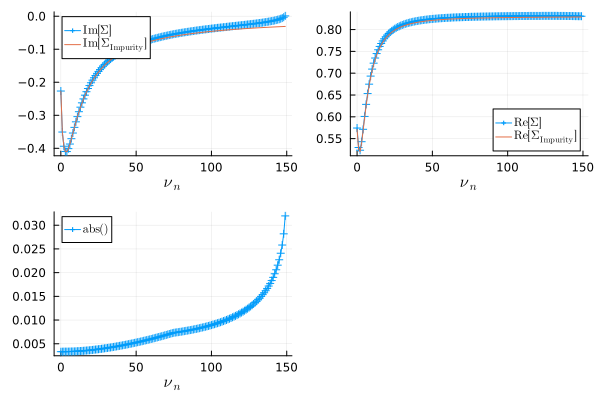

In [33]:
Fm = F_from_χ(lDGAhelper.χDMFT_m, lDGAhelper.gImp[1, :], sP, mP.β)
Fd = F_from_χ(lDGAhelper.χDMFT_d, lDGAhelper.gImp[1, :], sP, mP.β);
ΣLoc_m, ΣLoc_d = calc_local_EoM(Fm, Fd, lDGAhelper.gImp[1, :], mP, sP)
p1 = plot(imag(0.5 .* (ΣLoc_m .+ ΣLoc_d)),markershape=:auto, xlabel=L"\nu_n", label=L"\mathrm{Im}[\Sigma]")
plot!(imag(lDGAhelper.Σ_loc[axes(ΣLoc_m,1)]), label=L"\mathrm{Im}[\Sigma_\mathrm{Impurity}]")
p2 = plot(real(0.5 .* (ΣLoc_m .+ ΣLoc_d)),markershape=:auto, xlabel=L"\nu_n", label=L"\mathrm{Re}[\Sigma]")
plot!(real(lDGAhelper.Σ_loc[axes(ΣLoc_m,1)]), label=L"\mathrm{Re}[\Sigma_\mathrm{Impurity}]")
p3 = plot(abs.(0.5 .* (ΣLoc_m .+ ΣLoc_d) .- lDGAhelper.Σ_loc[axes(ΣLoc_m,1)]),markershape=:auto, xlabel=L"\nu_n", label=L"\mathrm{abs}()")
plot(p1, p2, p3)

In [34]:
using OffsetArrays
eom_ν_cutoff = LadderDGA.eom_ν_cutoff
Σ_hartree = LadderDGA.Σ_hartree
gridshape = LadderDGA.gridshape
ν0Index_of_ωIndex = LadderDGA.ν0Index_of_ωIndex

@inline eomf_test(U::Float64, γ_m::ComplexF64, γ_m2::ComplexF64, γ_d::ComplexF64, χ_m::Float64, χ_d::Float64, λ₀::ComplexF64)::ComplexF64 = U * (γ_m2 * 1.0 * (1 + U * χ_m) + γ_m * 0.5 * (1 + U * χ_m) - γ_d * 0.5 * (1 - U * χ_d) - 1.5 + 0.5 + λ₀)

function calc_Σ_test(χm::χT,γm::γT,χd::χT,γd::γT, χm_loc, λ₀,
                        Σ_loc::OffsetVector{ComplexF64}, Gνω::GνqT, kG, mP::ModelParameters, sP::SimulationParameters;
                        νmax::Int = eom_ν_cutoff(sP), λm::Float64 = 0.0, λd::Float64 = 0.0, nl_update::Bool=true
) 
    χm.λ != 0 && λm != 0 && error("Stopping self energy calculation: λm = $λm AND χm.λ = $(χm.λ)")
    χd.λ != 0 && λd != 0 && error("Stopping self energy calculation: λd = $λd AND χd.λ = $(χd.λ)")
    Nq, Nω = size(χm)
    ωrange::UnitRange{Int} = -sP.n_iω:sP.n_iω
    γm2 = deepcopy(γm)
    γd2 = deepcopy(γd)
    χm_loc = h.χ_m_loc
    χd_loc = h.χ_d_loc


    Kνωq_pre::Vector{ComplexF64} = Vector{ComplexF64}(undef, Nq)
    Σ_ladder = OffsetArray(Matrix{ComplexF64}(undef, Nq, νmax), 1:Nq, 0:νmax-1)
    Σ_ω = OffsetArray(Matrix{ComplexF64}(undef, Nq, νmax), 1:Nq, 0:νmax-1)
    λm != 0.0 && χ_λ!(χm, λm)
    λd != 0.0 && χ_λ!(χd, λd)
    χm_nl_loc = kintegrate(h.kG, χm,1)
    χd_nl_loc = kintegrate(h.kG, χd,1)
    for qi in axes(γm2, 1)
        for νi in axes(γm2, 2)
            if nl_update
                γm2[qi,νi,:] = γm[qi,νi,:] .* (1 .+ U .* χm_loc[1,:]) ./ (1 .+ U .* χm[qi, :])
            else
                γm2[qi,νi,:] = γm[qi,νi,:] .* (1 .+ U .* χm_loc[1,:]) ./ (1 .+ U .* χm_nl_loc[1, :])
            end
        end
    end
    ΣH = Σ_hartree(mP)
    νdim = ndims(Gνω) > 2 ? length(gridshape(kG)) + 1 : 2 # TODO: this is a fallback for gIm
    fill!(Σ_ω, zero(ComplexF64))
    ω_axis = χm.indices_ω
    for (ωi, ωn) in enumerate(ω_axis)
        νZero = ν0Index_of_ωIndex(ωi, sP)
        νlist = νZero:(sP.n_iν*2)
        length(νlist) > size(Σ_ω, 2) && (νlist = νlist[1:size(Σ_ω, 2)])
        for (νii, νi) in enumerate(νlist)
            for qi = axes(Σ_ω,1)
                @inbounds Kνωq_pre[qi] = eomf_test(U, γm[qi, νi, ωi], γm2[qi, νi, ωi], γd[qi, νi, ωi], χm[qi, ωi], χd[qi, ωi], λ₀[qi, νi, ωi])
            end
            #TODO: find a way to not unroll this!
            LadderDGA.conv_tmp_add!(view(Σ_ω, :, νii - 1), kG, Kνωq_pre, selectdim(Gνω, νdim, (νii - 1) + ωn))
        end
    end
    Σ_ladder = Σ_ω
    Σ_ladder.parent[:, :] = Σ_ladder.parent[:, :] ./ mP.β .+ .+ ΣH 

    λm != 0.0 && reset!(χm)
    λd != 0.0 && reset!(χd)
    return Σ_ladder
end

calc_Σ_test (generic function with 1 method)

In [35]:
mP = lDGAhelper.mP
kG = lDGAhelper.kG
U = mP.U
nden = mP.n
beta = mP.β
lim_se = U^2 * (nden/2) * (1 - nden/2)
se_tmp = calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper);

xr = collect(axes(se_tmp,2))
iν_arr = LadderDGA.iν_array(beta, xr)
gimp = lDGAhelper.gImp[1,xr];
res_dm     = LadderDGA.LambdaCorrection.λdm_correction(χm, γm, χd, γd, λ₀, lDGAhelper, tc = ΣTail_EoM); println(res_dm)

┌ Error: WARNING. SKIPPING λ correction because NaN is not finite!
└ @ LadderDGA.LambdaCorrection G:\Codes\LadderDGA.jl\src\LambdaCorrection\common.jl:43
╭──── λ-correction (type: LadderDGA.LambdaCorrection.dmCorrection),... ────────╮
│  λm = 0.02371567, λd = NaN, μ = 0.29877351                                   │
│  n      =  0.82980608,  n DMFT  =  0.82980608,  Δ = 0.0000%                  │
│  PP_1   =  0.24275851,  PP_2    =  0.24275851,  Δ = 0.0000%                  │
│  Epot_1 =  0.07762499,  Epot_2  =  0.05669002,  Δ = 15.5865%                 │
│  Ekin_1 =  -0.27297436,  Ekin_2  = -0.26047556,  Δ = 2.3430%                 │
│  χ_m    =  0.38655803,  χ_m_loc = 0.38383441,  Δ = 0.3535%                   │
│                                                                              │
╰──────────────────────────────────────────────────────────────────────────────╯



In [36]:
Fm = F_from_χ(:m, lDGAhelper)
Fd = F_from_χ(:d, lDGAhelper)
λ₀2 = calc_λ0(bubble, 1.0 .* (Fm), lDGAhelper; diag_zero=false);
λ₀Loc = calc_λ0(lDGAhelper.χ₀Loc, Fm, lDGAhelper.χ_m_loc, lDGAhelper.γ_m_loc, mP, sP)
kGridLoc = gen_kGrid(kGridsStr[1][1], 1)
Σ_ladderLoc = calc_Σ(lDGAhelper.χ_m_loc, lDGAhelper.γ_m_loc, lDGAhelper.χ_d_loc, lDGAhelper.γ_d_loc, lDGAhelper.χloc_m_sum,
        λ₀Loc, lDGAhelper.Σ_loc, lDGAhelper.gImp, kGridLoc, mP, sP, tc = ΣTail_Plain)

DBG: using diagonal terms in λ₀
DBG: NOT using diagonal terms in λ₀


1×100 OffsetArray(::Matrix{ComplexF64}, 1:1, 0:99) with eltype ComplexF64 with indices 1:1×0:99:
 0.511007-0.204439im  0.47345-0.313509im  …  0.826225-0.0456866im

In [37]:
λd_test = 150.0# -0.5# res_dm.λd
rhs_d0,PP_p1 = LadderDGA.LambdaCorrection.λm_rhs(χm, χd, lDGAhelper)
λm_d0  = LadderDGA.LambdaCorrection.λm_correction_val(χm, rhs_d0, lDGAhelper)
rhs,PP_p1 = LadderDGA.LambdaCorrection.λm_rhs(χm, χd, lDGAhelper, λd=λd_test)
λm  = LadderDGA.LambdaCorrection.λm_correction_val(χm, rhs, lDGAhelper)
println(λm)
se =  calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm, λd = λd_test, tc = ΣTail_Full)
se_ntc = calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm, λd = λd_test, tc = ΣTail_Plain);
se_new = calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm, λd = λd_test, tc = ΣTail_EoM);
se_parts =  calc_Σ_parts(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm, λd=λd_test)
se_parts_d0 =  calc_Σ_parts(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm_d0, λd=0.0);

-0.017128227551342044


DBG: NOT using diagonal terms in λ₀


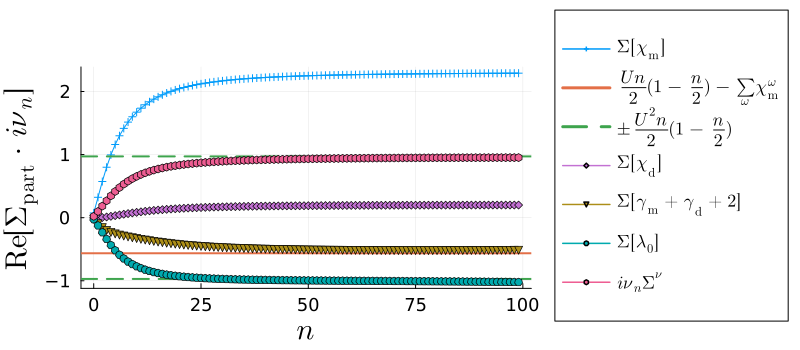

In [38]:
λ₀Loc = calc_λ0(lDGAhelper.χ₀Loc, Fm, lDGAhelper.χ_m_loc, lDGAhelper.γ_m_loc, mP, sP)
kGridLoc = gen_kGrid(kGridsStr[1][1], 1)
tc_m = sum_kω(kGridLoc, lDGAhelper.χ_m_loc)
tc_d = sum_kω(kGridLoc, lDGAhelper.χ_d_loc)
Σ_ladderLoc_parts = calc_Σ_parts(lDGAhelper.χ_m_loc, lDGAhelper.γ_m_loc, lDGAhelper.χ_d_loc, lDGAhelper.γ_d_loc, lDGAhelper.χloc_m_sum,
        λ₀Loc, lDGAhelper.Σ_loc, lDGAhelper.gImp, kGridLoc, mP, sP, tc = ΣTail_Plain);
gamma_sum = Σ_ladderLoc_parts[:,:,2] .+ Σ_ladderLoc_parts[:,:,4]  .+ Σ_ladderLoc_parts[:,:,5]
p = plot(xr, real(Σ_ladderLoc_parts[1,0:99,1] .* iν_arr),markershape=:auto, legend=:outerright, label = L"\Sigma[\chi_\mathrm{m}]", xlabel=L"n", ylabel= L"\mathrm{Re} [\Sigma_\mathrm{part} \cdot i\nu_n]",xtickfontsize=12,ytickfontsize=12,xguidefontsize=20,yguidefontsize=20,legendfontsize=12)
hline!(p, [- 2*U*tc_m + lim_se ], linewidth=2, label=L"\frac{Un}{2}(1-\frac{n}{2}) - \sum_\omega \chi^\omega_\mathrm{m}")
hline!(p, [-lim_se, lim_se], linewidth=2, linestyle=:dash, label=L"\pm \frac{U^2n}{2}(1-\frac{n}{2})",size=(800,350), top_margin=15mm, left_margin=5mm,bottom_margin=5mm)
plot!(p, xr, real(Σ_ladderLoc_parts[1,0:99,3] .* iν_arr), markershape=:auto, label = L"\Sigma[\chi_\mathrm{d}]")
plot!(p, xr, real(gamma_sum[1,0:99] .* iν_arr), markershape=:auto, label = L"\Sigma[\gamma_\mathrm{m} + \gamma_\mathrm{d} + 2]");
plot!(p, xr, real((Σ_ladderLoc_parts[1,0:99,6]) .* iν_arr), markershape=:auto, label = L"\Sigma[\lambda_0]");
plot!(p, xr, real(sum(Σ_ladderLoc_parts[1,0:99,1:6], dims=2)[:,1] .* iν_arr), markershape=:auto, label = L"i \nu_n\Sigma^\nu ")
savefig("SigmaParts.pdf")
display(p)

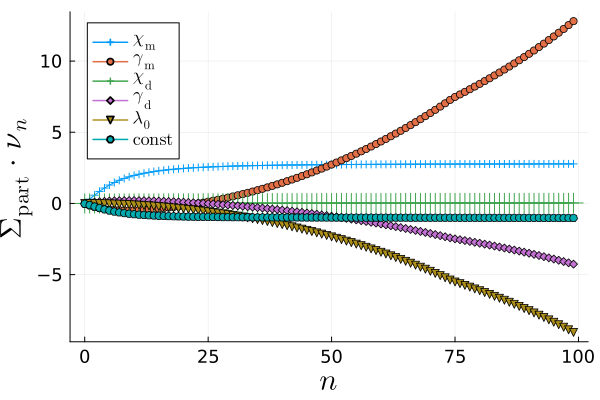

In [39]:
plot(xr, real(se_parts[1,0:99,1] .* iν_arr),markershape=:auto, legend=:topleft, label = L"\chi_\mathrm{m}", xlabel=L"n", ylabel= L"\Sigma_\mathrm{part} \cdot \nu_n",xtickfontsize=12,ytickfontsize=12,xguidefontsize=20,yguidefontsize=20,legendfontsize=12)
plot!(xr, real((se_parts[1,0:99,2]) .* iν_arr), markershape=:auto, label = L"\gamma_\mathrm{m}");
plot!(xr, real(se_parts[1,0:99,3] .* iν_arr), markershape=:auto, label = L"\chi_\mathrm{d}", markersize=10);
plot!(xr, real(se_parts[1,0:99,4] .* iν_arr), markershape=:auto, label = L"\gamma_\mathrm{d}");
plot!(xr, real(se_parts[1,0:99,5] .* iν_arr), markershape=:auto, label = L"\lambda_0");
plot!(xr, real((se_parts[1,0:99,6] .- U*1.0/2) .* iν_arr), markershape=:auto, label = L"\mathrm{const}")

In [40]:
plot(xr, real(se_parts2[1,0:99,1] .* iν_arr),markershape=:auto, legend=:outerright, label = L"\chi_\mathrm{m}", xlabel=L"n", ylabel= L"\Sigma_\mathrm{part} \cdot \nu_n",xtickfontsize=12,ytickfontsize=12,xguidefontsize=20,yguidefontsize=20,legendfontsize=12)
plot!(xr, real((se_parts2[1,0:99,2] .+ se_parts[1,0:99,4]  .+ se_parts[1,0:99,5] .+ se_parts[1,0:99,6]) .* iν_arr), markershape=:auto, label = L"\gamma_\mathrm{m} + \gamma_\mathrm{d} + \lambda_0 \mathrm{const}");
plot!(xr, real(se_parts2[1,0:99,3] .* iν_arr), markershape=:auto, label = L"\chi_\mathrm{d}")
plot!(xr, real(sum(se_parts2[1,0:99,1:6], dims=2)[:,1] .* iν_arr), markershape=:auto, label = L"i \nu_n\Sigma ")
hline!([-lim_se, lim_se], label=L"\pm \frac{U^2n}{2}(1-\frac{n}{2})",size=(800,300))

LoadError: UndefVarError: `se_parts2` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

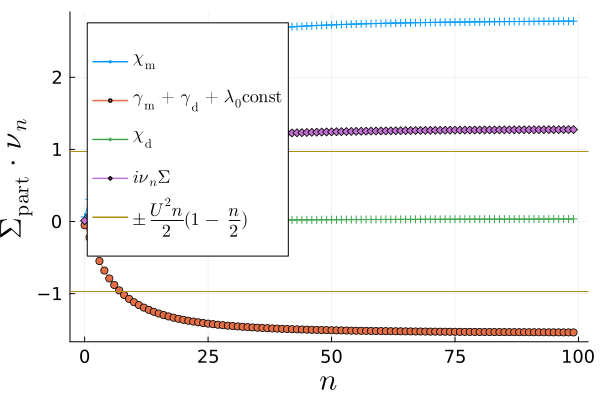

In [41]:
plot(xr, real(se_parts[1,0:99,1] .* iν_arr),markershape=:auto, legend=:topleft, label = L"\chi_\mathrm{m}", xlabel=L"n", ylabel= L"\Sigma_\mathrm{part} \cdot \nu_n",xtickfontsize=12,ytickfontsize=12,xguidefontsize=20,yguidefontsize=20,legendfontsize=12)
plot!(xr, real((se_parts[1,0:99,2] .+ se_parts[1,0:99,4]  .+ se_parts[1,0:99,5] .+ se_parts[1,0:99,6]) .* iν_arr), markershape=:auto, label = L"\gamma_\mathrm{m} + \gamma_\mathrm{d} + \lambda_0 \mathrm{const}");
plot!(xr, real(se_parts[1,0:99,3] .* iν_arr), markershape=:auto, label = L"\chi_\mathrm{d}")
plot!(xr, real(sum(se_parts[1,0:99,1:6], dims=2)[:,1] .* iν_arr), markershape=:auto, label = L"i \nu_n\Sigma ")
hline!([-lim_se, lim_se], label=L"\pm \frac{U^2n}{2}(1-\frac{n}{2})")

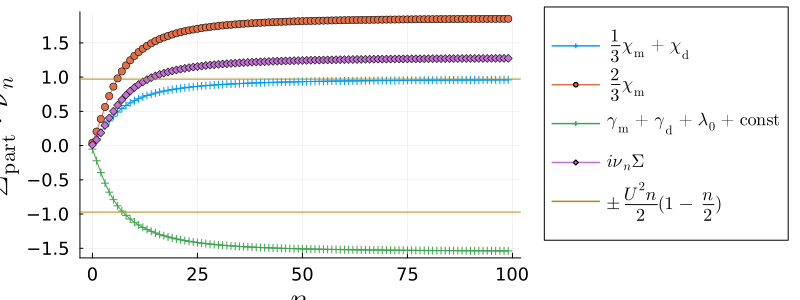

In [42]:
plot(xr, real(((1/3) * se_parts[1,0:99,1] .+ se_parts[1,0:99,3]) .* iν_arr),markershape=:auto, legend=:outerright, label = L"\frac{1}{3} \chi_\mathrm{m} + \chi_\mathrm{d}", xlabel=L"n", ylabel= L"\Sigma_\mathrm{part} \cdot \nu_n",xtickfontsize=12,ytickfontsize=12,xguidefontsize=20,yguidefontsize=20,legendfontsize=12)
plot!(xr, real(((2/3) * se_parts[1,0:99,1] ) .* iν_arr),markershape=:auto, label = L"\frac{2}{3} \chi_\mathrm{m}", xlabel=L"n", ylabel= L"\Sigma_\mathrm{part} \cdot \nu_n",xtickfontsize=12,ytickfontsize=12,xguidefontsize=20,yguidefontsize=20,legendfontsize=12)
plot!(xr, real((se_parts[1,0:99,2] .+ se_parts[1,0:99,4]  .+ se_parts[1,0:99,5] .+ se_parts[1,0:99,6]) .* iν_arr), markershape=:auto, label = L"\gamma_\mathrm{m} + \gamma_\mathrm{d} + \lambda_0 + \mathrm{const}");
plot!(xr, real(sum(se_parts[1,0:99,1:6], dims=2)[:,1] .* iν_arr), markershape=:auto, label = L"i \nu_n\Sigma ")
hline!([-lim_se, lim_se], label=L"\pm \frac{U^2n}{2}(1-\frac{n}{2})",size=(800,300))

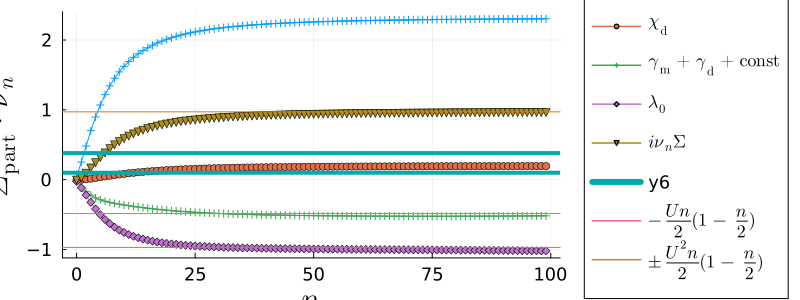

In [43]:
plot(xr, real(se_parts_d0[1,0:99,1] .* iν_arr),markershape=:auto, legend=:outerright, label = L"\chi_\mathrm{m}", xlabel=L"n", ylabel= L"\Sigma_\mathrm{part} \cdot \nu_n",xtickfontsize=12,ytickfontsize=12,xguidefontsize=20,yguidefontsize=20,legendfontsize=12)
plot!(xr, real(se_parts_d0[1,0:99,3] .* iν_arr), markershape=:auto, label = L"\chi_\mathrm{d}")
plot!(xr, real((se_parts_d0[1,0:99,2] .+ se_parts_d0[1,0:99,4]  .+ se_parts_d0[1,0:99,5]) .* iν_arr), markershape=:auto, label = L"\gamma_\mathrm{m} + \gamma_\mathrm{d} + \mathrm{const}");
plot!(xr, real((se_parts_d0[1,0:99,6]) .* iν_arr), markershape=:auto, label = L"\lambda_0");
plot!(xr, real(sum(se_parts_d0[1,0:99,1:6], dims=2)[:,1] .* iν_arr), markershape=:auto, label = L"i \nu_n\Sigma ")
cm = sum(lDGAhelper.χ_m_loc)/lDGAhelper.mP.β
cd = sum(lDGAhelper.χ_d_loc)/lDGAhelper.mP.β

hline!([cm, cd], linewidth=4)
hline!([-lim_se/U], label=L"- \frac{Un}{2}(1-\frac{n}{2})")
hline!([-lim_se, lim_se], label=L"\pm \frac{U^2n}{2}(1-\frac{n}{2})",size=(800,300))

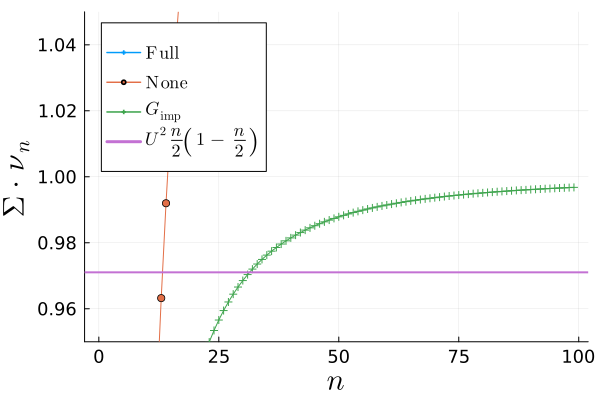

In [44]:
mP = lDGAhelper.mP
kG = lDGAhelper.kG
U = mP.U
nden = mP.n
beta = mP.β
lim_se = U^2 * (nden/2) * (1 - nden/2)
xr = collect(axes(se_ntc,2))
iν_arr = LadderDGA.iν_array(beta, xr)
gimp = lDGAhelper.gImp[1,xr]

plot(xr, real(se[1,:].parent .* iν_arr), ylims=(0.95,1.05), markershape=:auto, legend=:topleft, label = L"\mathrm{Full}", xlabel=L"n", ylabel= L"\Sigma \cdot \nu_n",xtickfontsize=12,ytickfontsize=12,xguidefontsize=20,yguidefontsize=20,legendfontsize=12)
plot!(xr, real(se_ntc[1,:].parent .* iν_arr), markershape=:auto, label = L"\mathrm{None}");
plot!(xr, real(gimp .* iν_arr), markershape=:auto, label = L"G_\mathrm{imp}")
hline!([lim_se], linewidth=2, label=L"U^2 \frac{n}{2} \left(1 - \frac{n}{2} \right)")

# Tail Correction gamma Test

Test is we can introduce tail correction by changing the tail of gamma^\nu\omega_q by diving out the DMFT susc and adding in the lambda corrected one.

In [45]:
h = lDGAhelper
#λm, λd_test
reset!(χm); reset!(χd)
se_test_nltc =  calc_Σ_test(χm, γm, χd, γd, h.χ_m_loc, λ₀, h.Σ_loc, h.gLoc_rfft, h.kG, h.mP, h.sP; λm = λm, λd = λd_test, nl_update=true);
se_test_loctc =  calc_Σ_test(χm, γm, χd, γd, h.χ_m_loc, λ₀, h.Σ_loc, h.gLoc_rfft, h.kG, h.mP, h.sP; λm = λm, λd = λd_test, nl_update=false);
se_test_full =  calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm, λd = λd_test, tc = ΣTail_Full);
se_test_plain =  calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm, λd = λd_test, tc = ΣTail_Plain);

In [46]:
res_m      = λm_correction(χm, γm, χd, γd, λ₀, lDGAhelper); print(res_m)

╭──── λ-correction (type: LadderDGA.LambdaCorrection.mCorrection),... ─────────╮
│  λm = 0.02371567, λd = 0.00000000, μ = 0.22269302                            │
│  n      =  0.82980608,  n DMFT  =  0.82980608,  Δ = 0.0000%                  │
│  PP_1   =  0.24275851,  PP_2    =  0.24275851,  Δ = 0.0000%                  │
│  Epot_1 =  0.06695451,  Epot_2  =  0.05669002,  Δ = 8.3016%                  │
│  Ekin_1 =  -0.27849941,  Ekin_2  = -0.26047556,  Δ = 3.3441%                 │
│  χ_m    =  0.38655803,  χ_m_loc = 0.38383441,  Δ = 0.3535%                   │
│                                                                              │
╰──────────────────────────────────────────────────────────────────────────────╯


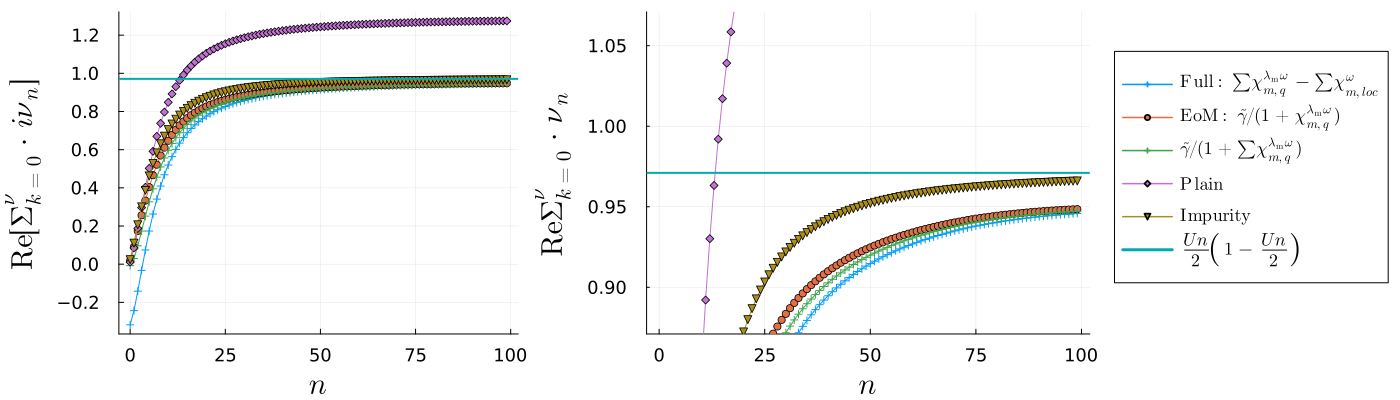

In [47]:
l = @layout [
    a{0.35w} b{0.65w}]
lim_se = U^2 * (nden/2) * (1 - nden/2)
xr = collect(axes(se_test_nltc,2))
iν_arr = LadderDGA.iν_array(beta, xr)
simp = lDGAhelper.Σ_loc[xr]


p1 = plot(xr, real(se_test_full[1,:].parent .* iν_arr),  markershape=:auto, label = L"\mathrm{Full:} \;\sum \chi^{\lambda_\mathrm{m}\omega}_{m,q} - \sum\chi^{\omega}_{m,loc}")
plot!(xr, real(se_test_nltc[1,:].parent .* iν_arr),  markershape=:auto, legend=nothing,  label = L"\mathrm{EoM:}\;\tilde{\gamma}/(1+\chi^{\lambda_\mathrm{m}\omega}_{m,q})",xlabel=L"n", ylabel= L"\mathrm{Re} [\Sigma^\nu_{k=0} \cdot i\nu_n]",xtickfontsize=12,ytickfontsize=12,xguidefontsize=20,yguidefontsize=20,legendfontsize=12)
plot!(xr, real(se_test_loctc[1,:].parent .* iν_arr),  markershape=:auto, label = L"\tilde{\gamma}/(1+\sum \chi^{\lambda_\mathrm{m}\omega}_{m,q})", )
plot!(xr, real(se_test_plain[1,:].parent .* iν_arr),  markershape=:auto, label = L"\mathrm{Plain}")
plot!(xr, real(simp .* iν_arr), markershape=:auto, label = L"\mathrm{imp}")
hline!([lim_se], label=L"\frac{Un}{2}\left(1-\frac{Un}{2}\right)", lw=2)

p2 = plot(xr, real(se_test_full[1,:].parent .* iν_arr),  markershape=:auto, label = L"\mathrm{Full:} \;\sum \chi^{\lambda_\mathrm{m}\omega}_{m,q} - \sum\chi^{\omega}_{m,loc}")
plot!(xr, real(se_test_nltc[1,:].parent .* iν_arr), ylims=(lim_se-0.1, lim_se+0.1),  markershape=:auto, legend=:outerright, label = L"\mathrm{EoM:}\;\tilde{\gamma}/(1+\chi^{\lambda_\mathrm{m}\omega}_{m,q})", xlabel=L"n", ylabel= L"\mathrm{Re} \Sigma^\nu_{k=0} \cdot \nu_n",xtickfontsize=12,ytickfontsize=12,xguidefontsize=20,yguidefontsize=20,legendfontsize=12)
plot!(xr, real(se_test_loctc[1,:].parent .* iν_arr),  markershape=:auto, label = L"\tilde{\gamma}/(1+\sum \chi^{\lambda_\mathrm{m}\omega}_{m,q})" )
plot!(xr, real(se_test_plain[1,:].parent .* iν_arr),  markershape=:auto, label = L"\mathrm{Plain}")
plot!(xr, real(simp .* iν_arr), markershape=:auto, label = L"\mathrm{Impurity}")
hline!([lim_se], label=L"\frac{Un}{2}\left(1-\frac{Un}{2}\right)", lw=2)

p = plot(p1, p2, layout=l, size=(1400,400), left_margin=10mm, bottom_margin=8mm)
savefig("mu$mu_str.pdf")
display(p)

In [52]:

res_dm     = LadderDGA.LambdaCorrection.λdm_correction(χm, γm, χd, γd, λ₀, lDGAhelper, tc = ΣTail_Full); println(res_dm)
λd_test = res_dm.λd
rhs,PP_p1 = LadderDGA.LambdaCorrection.λm_rhs(χm, χd, lDGAhelper, λd=λd_test)
λm  = LadderDGA.LambdaCorrection.λm_correction_val(χm, rhs, lDGAhelper)
se_test_nltc =  calc_Σ_test(χm, γm, χd, γd, h.χ_m_loc, λ₀, h.Σ_loc, h.gLoc_rfft, h.kG, h.mP, h.sP; λm = λm, λd = λd_test, nl_update=true);
se_test_loctc =  calc_Σ_test(χm, γm, χd, γd, h.χ_m_loc, λ₀, h.Σ_loc, h.gLoc_rfft, h.kG, h.mP, h.sP; λm = λm, λd = λd_test, nl_update=false);
se_test_full =  calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm, λd = λd_test, tc = ΣTail_Full);
se_test_plain =  calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm, λd = λd_test, tc = ΣTail_Plain);

┌ Error: WARNING. SKIPPING λ correction because NaN is not finite!
└ @ LadderDGA.LambdaCorrection G:\Codes\LadderDGA.jl\src\LambdaCorrection\common.jl:43
╭──── λ-correction (type: LadderDGA.LambdaCorrection.dmCorrection),... ────────╮
│  λm = 0.02371567, λd = NaN, μ = 0.21216731                                   │
│  n      =  0.82980608,  n DMFT  =  0.82980608,  Δ = 0.0000%                  │
│  PP_1   =  0.24275851,  PP_2    =  0.24275851,  Δ = 0.0000%                  │
│  Epot_1 =  0.07330256,  Epot_2  =  0.05669002,  Δ = 12.7796%                 │
│  Ekin_1 =  -0.28722210,  Ekin_2  = -0.26047556,  Δ = 4.8835%                 │
│  χ_m    =  0.38655803,  χ_m_loc = 0.38383441,  Δ = 0.3535%                   │
│                                                                              │
╰──────────────────────────────────────────────────────────────────────────────╯

┌ Error: WARNING. SKIPPING λ correction because NaN is not finite!
└ @ LadderDGA.LambdaCorrection G:\Codes\LadderDGA

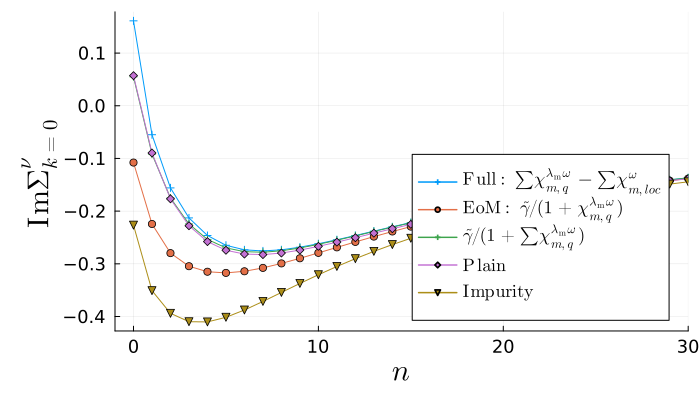

In [53]:
p1 = plot(xr, imag(se_test_full[1,:].parent),  markershape=:auto, label = L"\mathrm{Full:} \;\sum \chi^{\lambda_\mathrm{m}\omega}_{m,q} - \sum\chi^{\omega}_{m,loc}")
plot!(xr, imag(se_test_nltc[1,:].parent),  markershape=:auto, legend=:bottomright, label = L"\mathrm{EoM:}\;\tilde{\gamma}/(1+\chi^{\lambda_\mathrm{m}\omega}_{m,q})", xlabel=L"n", ylabel= L"\mathrm{Im} \Sigma^\nu_{k=0}",xtickfontsize=12,ytickfontsize=12,xguidefontsize=20,yguidefontsize=20,legendfontsize=12)
plot!(xr, imag(se_test_loctc[1,:].parent),  markershape=:auto, label = L"\tilde{\gamma}/(1+\sum \chi^{\lambda_\mathrm{m}\omega}_{m,q})", )
plot!(xr, imag(se_test_plain[1,:].parent),  markershape=:auto, label = L"\mathrm{Plain}")
plot!(xr, imag(simp), markershape=:auto, label = L"\mathrm{Impurity}")

p = plot(p1,size=(700,400),xlims=(-1,30), left_margin=8mm, bottom_margin=5mm)
savefig("mu$(mu_str)_se.pdf")
display(p)

┌ Error: WARNING. SKIPPING λ correction because NaN is not finite!
└ @ LadderDGA.LambdaCorrection G:\Codes\LadderDGA.jl\src\LambdaCorrection\common.jl:43
┌ Error: WARNING. SKIPPING λ correction because NaN is not finite!
└ @ LadderDGA.LambdaCorrection G:\Codes\LadderDGA.jl\src\LambdaCorrection\common.jl:43
┌ Error: WARNING. SKIPPING λ correction because NaN is not finite!
└ @ LadderDGA.LambdaCorrection G:\Codes\LadderDGA.jl\src\LambdaCorrection\common.jl:43
┌ Error: WARNING. SKIPPING λ correction because NaN is not finite!
└ @ LadderDGA.LambdaCorrection G:\Codes\LadderDGA.jl\src\LambdaCorrection\common.jl:43
┌ Error: WARNING. SKIPPING λ correction because NaN is not finite!
└ @ LadderDGA.LambdaCorrection G:\Codes\LadderDGA.jl\src\LambdaCorrection\common.jl:43


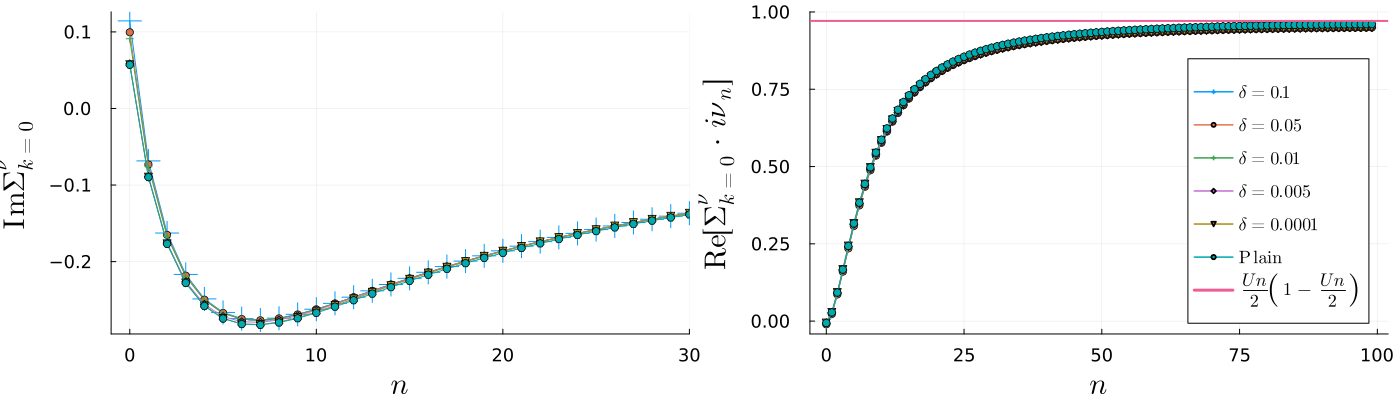

In [51]:
se_test_exps_01 =  calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm, λd = λd_test, tc = ΣTail_ExpStep{1.5});
se_test_exps_05 =  calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm, λd = λd_test, tc = ΣTail_ExpStep{1.0});
se_test_exps_001 =  calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm, λd = λd_test, tc = ΣTail_ExpStep{0.8});
se_test_exps_005 =  calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm, λd = λd_test, tc = ΣTail_ExpStep{0.2});
se_test_exps_00001 =  calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm, λd = λd_test, tc = ΣTail_ExpStep{0.05});

p1 = plot(xr, imag(se_test_exps_01[1,:].parent),xlims=(-1,30),  markershape=:auto, legend=nothing, label = L"\delta=0.1", markersize=12, xlabel=L"n", ylabel= L"\mathrm{Im} \Sigma^\nu_{k=0}",xtickfontsize=12,ytickfontsize=12,xguidefontsize=20,yguidefontsize=20,legendfontsize=12)
plot!(xr, imag(se_test_exps_05[1,:].parent),  markershape=:auto, label = L"\delta=0.05", )
plot!(xr, imag(se_test_exps_001[1,:].parent),  markershape=:auto, label = L"\delta=0.01", )
plot!(xr, imag(se_test_exps_005[1,:].parent),  markershape=:auto, label = L"\delta=0.005")
plot!(xr, imag(se_test_exps_00001[1,:].parent),  markershape=:auto, label = L"\delta=0.0001")
plot!(xr, imag(se_test_plain[1,:].parent), markershape=:auto, label = L"\mathrm{Plain}")

p2 = plot(xr, real(se_test_exps_01[1,:].parent .* iν_arr),markershape=:auto, legend=:bottomright, xlabel=L"n", label = L"\delta=0.1",  ylabel= L"\mathrm{Re} [\Sigma^\nu_{k=0} \cdot i\nu_n]",xtickfontsize=12,ytickfontsize=12,xguidefontsize=20,yguidefontsize=20,legendfontsize=12)
plot!(xr, real(se_test_exps_05[1,:].parent .* iν_arr),  markershape=:auto, label = L"\delta=0.05", )
plot!(xr, real(se_test_exps_001[1,:].parent .* iν_arr),  markershape=:auto, label = L"\delta=0.01", )
plot!(xr, real(se_test_exps_005[1,:].parent .* iν_arr),  markershape=:auto, label = L"\delta=0.005")
plot!(xr, real(se_test_exps_00001[1,:].parent .* iν_arr),  markershape=:auto, label = L"\delta=0.0001")
plot!(xr, real(se_test_plain[1,:].parent .* iν_arr), markershape=:auto, label = L"\mathrm{Plain}")
hline!([lim_se], label=L"\frac{Un}{2}\left(1-\frac{Un}{2}\right)", lw=2)

p = plot(p1,p2,size=(1400,400), left_margin=8mm, bottom_margin=8mm)
savefig("mu$(mu_str)_se_exp.pdf")
display(p)

# Lambda Correction Test

In [19]:
res_m_ntc  = λm_correction(χm, γm, χd, γd, λ₀, lDGAhelper, tc=ΣTail_Plain)

╭──── λ-correction (type: LadderDGA.LambdaCorrection.mCorrection),... ─────────╮
│  λm = 0.08750195, λd = 0.00000000, μ = 0.97334360                            │
│  n      =  0.99803265,  n DMFT  =  0.99803265,  Δ = 0.0000%                  │
│  PP_1   =  0.24999903,  PP_2    =  0.24999903,  Δ = 0.0000%                  │
│  Epot_1 =  0.10714105,  Epot_2  =  0.12356106,  Δ = 7.1174%                  │
│  Ekin_1 =  -0.22117363,  Ekin_2  = -0.20903607,  Δ = 2.8213%                 │
│  χ_m    =  0.43723579,  χ_m_loc = 0.43558908,  Δ = 0.1887%                   │
│                                                                              │
╰──────────────────────────────────────────────────────────────────────────────╯


In [20]:
res_dm_f     = λdm_correction(χm, γm, χd, γd, λ₀, lDGAhelper)


╭──── λ-correction (type: LadderDGA.LambdaCorrection.dmCorrection),... ────────╮
│  λm = 0.05310853, λd = 3.32392058, μ = 0.98500700                            │
│  n      =  0.99803265,  n DMFT  =  0.99803265,  Δ = 0.0000%                  │
│  PP_1   =  0.24999903,  PP_2    =  0.24999903,  Δ = 0.0000%                  │
│  Epot_1 =  0.11542236,  Epot_2  =  0.10845233,  Δ = 3.1134%                  │
│  Ekin_1 =  -0.22061606,  Ekin_2  = -0.20903607,  Δ = 2.6952%                 │
│  χ_m    =  0.44479016,  χ_m_loc = 0.43558908,  Δ = 1.0451%                   │
│                                                                              │
╰──────────────────────────────────────────────────────────────────────────────╯


In [ ]:
res_m_f      = λm_correction(χm, γm, χd, γd, λ₀, lDGAhelper, tc=ΣTail_Full)
res_m_s      = λm_correction(χm, γm, χd, γd, λ₀, lDGAhelper, tc=ΣTail_ExpStep{LadderDGA.default_ΣTail_ExpStep_δ})
res_dm_ntc = λdm_correction(χm, γm, χd, γd, λ₀, lDGAhelper, tc=ΣTail_Plain)
res_dm_f     = λdm_correction(χm, γm, χd, γd, λ₀, lDGAhelper, tc=ΣTail_Full)
res_dm_s     = λdm_correction(χm, γm, χd, γd, λ₀, lDGAhelper, tc=ΣTail_ExpStep{LadderDGA.default_ΣTail_ExpStep_δ})

In [ ]:

function Cond_Causal(χm::χT,γm::γT,χd::χT, γd::γT,λ₀, h; 
    λm::Float64 = NaN, λd::Float64 = NaN, 
    νmax::Int = LadderDGA.eom_ν_cutoff(h), fix_n::Bool = true, tc::Type{<: ΣTail} = LadderDGA.default_Σ_tail_correction(),
    validation_threshold::Float64 = 1e-8, max_steps_m::Int = 2000,
    max_steps_dm::Int = 2000, log_io = devnull
)
    μ_new, G_ladder, Σ_ladder = calc_G_Σ(χm, γm, χd, γd, λ₀, λm, λd, h; νmax=νmax, tc = tc, fix_n = fix_n)
    ef = estimate_ef(Σ_ladder, h.kG, μ_new, h.mP.β)
    SC_2 = any(ef) ? maximum(imag.(Σ_ladder[ef,0])) : NaN
    return maximum(imag.(Σ_ladder[:,0])), SC_2
end

In [ ]:
PP_1, PP_2 = Cond_PauliPrinciple(χm, γm, χd, γd, λ₀, lDGAhelper; tc = ΣTail_Plain, λm = λm_i, λd = λd_i)
EP_1, EP_2 = Cond_EPot(χm, γm, χd, γd, λ₀, lDGAhelper; tc = ΣTail_Plain, λm = λm_i, λd = λd_i)
EK_1, EK_2 = Cond_EKin(χm, γm, χd, γd, λ₀, lDGAhelper; tc = ΣTail_Plain, λm = λm_i, λd = λd_i)
ST_1, ST_2 = Cond_Tail(χm, γm, χd, γd, λ₀, lDGAhelper; tc = ΣTail_Plain, λm = λm_i, λd = λd_i)
SC_1, SC_2 = Cond_Causal(χm, γm, χd, γd, λ₀, lDGAhelper; tc = ΣTail_Plain, λm = λm_i, λd = λd_i)

In [ ]:
λm_i = 0.0
λd_i = 0.0
Δλ = 0.08
nh = LadderDGA.ω0_index(χd)
λm_r =(-minimum(1 ./ view(χm, :, nh)) + 0.0001):(Δλ/150.0):0.15
λd_r = (-minimum(1 ./ view(χd, :, nh)) + 0.005):Δλ:1.0
tt = Array{ComplexF64,3}(undef, length(λm_r), length(λd_r),12)
for (i,λd_i) in enumerate(λd_r)
    println("$i of $(length(λd_r))")
    for (j,λm_i) in enumerate(λm_r)
        PP_1, PP_2 = Cond_PauliPrinciple(χm, γm, χd, γd, λ₀, lDGAhelper; tc = ΣTail_Plain, λm = λm_i, λd = λd_i)
        EP_1, EP_2 = Cond_EPot(χm, γm, χd, γd, λ₀, lDGAhelper; tc = ΣTail_Plain, λm = λm_i, λd = λd_i)
        EK_1, EK_2 = Cond_EKin(χm, γm, χd, γd, λ₀, lDGAhelper; tc = ΣTail_Plain, λm = λm_i, λd = λd_i)
        ST_1, ST_2 = Cond_Tail(χm, γm, χd, γd, λ₀, lDGAhelper; tc = ΣTail_Plain, λm = λm_i, λd = λd_i)
        SC_1, SC_2 = Cond_Causal(χm, γm, χd, γd, λ₀, lDGAhelper; tc = ΣTail_Plain, λm = λm_i, λd = λd_i)
        tt[j,i,:] = [λm_i, λd_i, PP_1, PP_2, EP_1, EP_2, EK_1, EK_2, ST_1, ST_2, SC_1, SC_2]
    end
end


In [ ]:
heatmap(λm_r, λd_r, log.(abs.(real(tt[:,:,3] .- tt[:,:,4])))', xlabel=L"\lambda_\mathrm{m}", ylabel=L"\lambda_\mathrm{d}", title=L"\mathrm{PP}^{(1)} - \mathrm{PP}^{(2)}")

In [ ]:
heatmap(λm_r, λd_r, log.(abs.(real(tt[:,:,5] .- tt[:,:,6])))', xlabel=L"\lambda_\mathrm{m}", ylabel=L"\lambda_\mathrm{d}", title=L"E_\mathrm{pot}^{(1)} - E_\mathrm{pot}^{(2)}")

In [ ]:
heatmap(λm_r, λd_r, log.(abs.(real(tt[:,:,7] .- tt[:,:,8])))', xlabel=L"\lambda_\mathrm{m}", ylabel=L"\lambda_\mathrm{d}", title=L"E_\mathrm{kin}^{(1)} - E_\mathrm{kin}^{(2)}")

In [ ]:
heatmap( λm_r, λd_r, log.(abs.(real(tt[:,:,9] .- tt[:,:,10])))', xlabel=L"\lambda_\mathrm{m}", ylabel=L"\lambda_\mathrm{d}", title=L"\Sigma_\mathrm{Tail}^{(1)} - \Sigma_\mathrm{Tail}^{(2)}")

In [ ]:
heatmap( λm_r, λd_r, real(tt[:,:,11])', clims=(-0.5,0.01), xlabel=L"\lambda_\mathrm{m}", ylabel=L"\lambda_\mathrm{d}", title=L"\max \{\mathrm{Im} \Sigma^{i\nu_0}_\mathrm{k}\}")

In [ ]:
heatmap( λm_r, λd_r, real(tt[:,:,12])', clims=(-0.8,0.1), xlabel=L"\lambda_\mathrm{m}", ylabel=L"\lambda_\mathrm{d}", title=L"\max \{\mathrm{Im} \Sigma^{i\nu_0}_\mathrm{k}\}")

In [ ]:
real(tt[1,:,12])'

In [ ]:
tttt = log.(abs.(real(tt[:,:,9] .- tt[:,:,10])))'
plot(tttt[1,:]) 

In [ ]:
isfinite(0)

In [ ]:
j_p = 1
i_p = 1
plot(imag(tt[j_p,i_p][1,:,7]), markershape=:auto, label="λm = $(λm_r[j_p]) λd = $(λd_r[i_p])")
j_p = 1
i_p = 1
plot!(imag(tt[j_p,i_p][1,:,7]), markershape=:auto, label="λm = $(λm_r[j_p]) λd = $(λd_r[i_p])")

In [ ]:
res_m_ntc  = λm_correction(χm, γm, χd, γd, λ₀, lDGAhelper, tc=ΣTail_Plain)
res_m      = λm_correction(χm, γm, χd, γd, λ₀, lDGAhelper, tc=ΣTail_Full)
res_dm_ntc = λdm_correction(χm, γm, χd, γd, λ₀, lDGAhelper, tc=ΣTail_Plain)
res_dm     = λdm_correction(χm, γm, χd, γd, λ₀, lDGAhelper, tc=ΣTail_Full)

In [ ]:

#se_ntc
λm_test = res_dm_ntc.λm
λd_test = res_dm_ntc.λd
Σλ_ntc = calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm_test, λd = λd_test, tc = ΣTail_Plain);
Σλ_tc = calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm_test, λd = λd_test, tc = ΣTail_Full);
tc_factor_full = LadderDGA.tail_factor(ΣTail_Full, mP.U, mP.β, mP.n, lDGAhelper.Σ_loc, iν_arr)
tc_factor_exp_1 = LadderDGA.tail_factor(ΣTail_ExpStep{0.001}, mP.U, mP.β, mP.n, lDGAhelper.Σ_loc, iν_arr)
tc_factor_exp_2 = LadderDGA.tail_factor(ΣTail_ExpStep{0.05}, mP.U, mP.β, mP.n, lDGAhelper.Σ_loc, iν_arr)
tc_factor_exp_3 = LadderDGA.tail_factor(ΣTail_ExpStep{0.1}, mP.U, mP.β, mP.n, lDGAhelper.Σ_loc, iν_arr)
tc_term_full  = LadderDGA.tail_correction_term(sum_kω(kG, χm, λ = λm_test), lDGAhelper.χloc_m_sum, tc_factor_full)
tc_term_exp_1  = LadderDGA.tail_correction_term(sum_kω(kG, χm, λ = λm_test), lDGAhelper.χloc_m_sum, tc_factor_exp_1)
tc_term_exp_2  = LadderDGA.tail_correction_term(sum_kω(kG, χm, λ = λm_test), lDGAhelper.χloc_m_sum, tc_factor_exp_2)
tc_term_exp_3  = LadderDGA.tail_correction_term(sum_kω(kG, χm, λ = λm_test), lDGAhelper.χloc_m_sum, tc_factor_exp_3)

plot(xr, real(Σλ_ntc[1,:].parent .* iν_arr), ylims=(0.85,1.25), markershape=:auto, legend=:topright, label = L"\mathrm{plain}", xlabel=L"n", ylabel= L"\Sigma \cdot \nu_n",xtickfontsize=12,ytickfontsize=12,xguidefontsize=20,yguidefontsize=20,legendfontsize=12)
#plot!(xr, real(Σλ_tc[1,:].parent .* iν_arr), markershape=:auto, label = L"\mathrm{improved}")
plot!(xr, real((Σλ_ntc[:,:].parent .+ (tc_term_full ))[1,:] .* iν_arr), markershape=:auto, label = L"\mathrm{impr., full}")
plot!(xr, real((Σλ_ntc[:,:].parent .+ (tc_term_exp_1  ))[1,:] .* iν_arr), markershape=:auto, label = L"\mathrm{impr., step}")
plot!(xr, real(gimp .* iν_arr), markershape=:auto, label = L"G_\mathrm{imp}")
hline!([lim_se], linewidth=2, label=L"U^2 \frac{n}{2} \left(1 - \frac{n}{2} \right)")
#

In [ ]:
tc_term_exp_1  = LadderDGA.tail_correction_term(sum_kω(kG, χm, λ = λm_test), lDGAhelper.χloc_m_sum, tc_factor_exp_1)
tc_term_exp_2  = LadderDGA.tail_correction_term(sum_kω(kG, χm, λ = λm_test), lDGAhelper.χloc_m_sum, tc_factor_exp_2)
tc_term_exp_3  = LadderDGA.tail_correction_term(sum_kω(kG, χm, λ = λm_test), lDGAhelper.χloc_m_sum, tc_factor_exp_3)

plot(xr, real(Σλ_ntc[1,:].parent .* iν_arr), ylims=(0.85,1.25), size=(800,400), markershape=:auto, legend=:outerright, label = L"\mathrm{plain}", xlabel=L"n", ylabel= L"\Sigma \cdot \nu_n",xtickfontsize=12,ytickfontsize=12,xguidefontsize=20,yguidefontsize=20,legendfontsize=12)
#plot!(xr, real(Σλ_tc[1,:].parent .* iν_arr), markershape=:auto, label = L"\mathrm{improved}")
#plot!(xr, real((Σλ_ntc[:,:].parent .+ (tc_term_full ))[1,:] .* iν_arr), markershape=:auto, label = L"\mathrm{impr., full}")
plot!(xr, real((Σλ_ntc[:,:].parent .+ (tc_term_exp_1 ))[1,:] .* iν_arr), markershape=:auto, label = L"\mathrm{impr., step}, \delta=0.001")
plot!(xr, real((Σλ_ntc[:,:].parent .+ (tc_term_exp_2 ))[1,:] .* iν_arr), markershape=:auto, label = L"\mathrm{impr., step}, \delta=0.05=\frac{1}{\beta}")
plot!(xr, real((Σλ_ntc[:,:].parent .+ (tc_term_exp_3 ))[1,:] .* iν_arr), markershape=:auto, label = L"\mathrm{impr., step}, \delta=0.1")
plot!(xr, real(gimp .* iν_arr), markershape=:auto, label = L"G_\mathrm{imp}")
hline!([lim_se], linewidth=2, label=L"U^2 \frac{n}{2} \left(1 - \frac{n}{2} \right)")

In [ ]:
plot(xr, imag(Σλ_ntc[1,:].parent), xlims=(-1,20), ylims=(-0.8,0.0),markershape=:auto, markersize=10, legend=:bottomright,label = L"\mathrm{plain}", xlabel=L"n", ylabel= L"\Sigma",xtickfontsize=12,ytickfontsize=12,xguidefontsize=20,yguidefontsize=20,legendfontsize=12)
plot!(xr, imag(Σλ_tc[1,:].parent), markershape=:auto, label = L"\mathrm{impr, full}")
plot!(xr, imag((Σλ_ntc[:,:].parent .+ (tc_term_exp_1 ))[1,:]), markershape=:auto, label = L"\mathrm{impr., step}, δ=0.001")
plot!(xr, imag((Σλ_ntc[:,:].parent .+ (tc_term_exp_2 ))[1,:]), markershape=:auto, label = L"\mathrm{impr., step}, δ=0.01")
plot!(xr, imag((Σλ_ntc[:,:].parent .+ (tc_term_exp_3 ))[1,:]), markershape=:auto, label = L"\mathrm{impr., step}, δ=0.1")
#plot!(xr, imag(gimp ), markershape=:auto, label = L"G_\mathrm{imp}")

In [ ]:
xr_dm_01, fr_dm_01 = LadderDGA.LambdaCorrection.EPotCond_curve(χm,γm,χd,γd,λ₀, lDGAhelper; maxit=1000, λmin=-9.5, λmax=1.0, tc=:plain)
xr_dm_02, fr_dm_02 = LadderDGA.LambdaCorrection.EPotCond_curve(χm,γm,χd,γd,λ₀, lDGAhelper; maxit=120,  λmin=-9.5, λmax=1.0, tc=:full)
xr_dm_03, fr_dm_03 = LadderDGA.LambdaCorrection.EPotCond_curve(χm,γm,χd,γd,λ₀, lDGAhelper; maxit=1000, λmin=-9.5, λmax=1.0);

In [ ]:
xr_dm_03, fr_dm_03 = LadderDGA.LambdaCorrection.EPotCond_curve(χm,γm,χd,γd,λ₀, lDGAhelper; maxit=1000, λmin=-9.5, λmax=1.0);

In [ ]:
plot(xr_dm_01, fr_dm_01, size=(800,500), linewidth=2, ylims=(-.2,.2), xlims=(-9.9,2), ylabel=L"\Delta E_\mathrm{pot}", xlabel=L"\lambda_d", label=L"\mathrm{plain}",xtickfontsize=12,ytickfontsize=12,xguidefontsize=20,yguidefontsize=20,legendfontsize=12, markershape=:auto)
plot!(xr_dm_02, fr_dm_02, label=L"\mathrm{full}")
plot!(xr_dm_03, fr_dm_03, label=L"\mathrm{step}", markershape=:auto)
vline!([-9.07], label="-9.07")

In [ ]:
λd_range = LinRange(-9.5, -5.0, 100)
se_ntc_list = []
se_ftc_list = []
se_etc_list = []
largest_ind_ntc = []
largest_ind_ftc = []
h = lDGAhelper;
for λd_test in λd_range
    rhs_c1,_ = LadderDGA.LambdaCorrection.λm_rhs(χm, χd, h; λd=λd_test)
    ωn2_tail = LadderDGA.ω2_tail(χm)
    λm_test =  LadderDGA.LambdaCorrection.λm_correction_val(χm, rhs_c1, h.kG, ωn2_tail)
    
    se_ntc = calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm_test, λd = λd_test, tc = :plain);
    se_ftc = calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm_test, λd = λd_test, tc = :full);
    #se_etc = calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm_test, λd = λd_test, tc = :exp_step);
    _,ind = findmax(imag(se_ntc[:,0]))
    push!(largest_ind_ntc, ind)
    _,ind = findmax(imag(se_ftc[:,0]))
    push!(largest_ind_ftc, ind)
    push!(se_ntc_list, imag(se_ntc[end-5,0]))
    push!(se_ftc_list, imag(se_ftc[end-5,0]))
    #push!(se_etc_list, imag(se_etc[1,0]))
end

In [ ]:
lDGAhelper.kG.kGrid

In [ ]:
plot(λd_range, se_ntc_list, markershape=:auto, markersize=8, ylims=(-5,2), xlabel=L"\lambda_\mathrm{d}", ylabel=L"\Sigma^{\nu_0}_{k=0}", label=L"\mathrm{Plain}")
plot!(λd_range, se_ftc_list, markershape=:auto, xlabel=L"\lambda_\mathrm{d}", ylabel=L"\Sigma^{\nu_0}_{k=0}", label=L"\mathrm{Full}")
#plot!(λd_range, se_etc_list, markershape=:auto, xlabel=L"\lambda_\mathrm{d}", ylabel=L"\Sigma^{\nu_0}_{k=0}", label=L"\mathrm{Step}")
vline!([-9.07], label="-9.07")

In [ ]:
plot(λd_range,largest_ind_ntc, markershape=:auto,  xlabel=L"\lambda_\mathrm{d}", ylabel="k-index with larges Im(Σ[0])")
plot!(λd_range,largest_ind_ftc, markershape=:auto)

In [ ]:
λd_range = LinRange(-10.5, 30.0, 100)
se_ntc_list = []
se_ftc_list = []
#se_etc_list = []
h = lDGAhelper;
for λd_test in λd_range
    rhs_c1,_ = LadderDGA.LambdaCorrection.λm_rhs(χm, χd, h; λd=λd_test)
    ωn2_tail = LadderDGA.ω2_tail(χm)
    λm_test =  LadderDGA.LambdaCorrection.λm_correction_val(χm, rhs_c1, h.kG, ωn2_tail)
    
    se_ntc = calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm_test, λd = λd_test, tc = :plain);
    se_ftc = calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm_test, λd = λd_test, tc = :full);
    #se_etc = calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm_test, λd = λd_test, tc = :exp_step);
    push!(se_ntc_list, imag(se_ntc[1,0]))
    push!(se_ftc_list, imag(se_ftc[1,0]))
    #push!(se_etc_list, imag(se_etc[1,0]))
end

In [ ]:
plot(λd_range, se_ntc_list, markershape=:auto, markersize=8, ylims=(-3,1), xlabel=L"\lambda_\mathrm{d}", ylabel=L"\Sigma^{\nu_0}_{k=0}", label=L"\mathrm{Plain}")
plot!(λd_range, se_ftc_list, markershape=:auto, xlabel=L"\lambda_\mathrm{d}", ylabel=L"\Sigma^{\nu_0}_{k=0}", label=L"\mathrm{Full}")
vline!([-9.37], label="-9.07", linewidth=3)

In [ ]:
using OffsetArrays, TimerOutputs
ω0_index = LadderDGA.ω0_index
calc_Σ! = LadderDGA.calc_Σ!
lmax = get_λd_min(χm, γm, χd, γd, λ₀, lDGAhelper)

In [ ]:
plot(xr[2:end], tt, markershape=:auto)
plot!(xr[1:end], t1, markershape=:auto, xlims=(-10,-5))
vline!([lmax])

In [ ]:
a = randn(4,5)

In [ ]:
maximum(a)